<h1> Applied Data Science Capstone Week 4 and 5 </h1>

## Introduction <a name="introduction"></a>

This project looks at the relationships between residential project values and the number of surrounding venues. It is likely that new residential projects are constructed with the consideration of surrounding facilities. Thus larger residential project investments may correlate with greater numbers of neighbouring venues. 

## Data <a name="data"></a>

This project will restrict to **2019 new residential buildings** in the city of **Baton Rouge, Louisiana**. Residentail project value data is found at https://data.brla.gov/Housing-and-Development/New-Residential-Building-Permits-by-Month/2vpm-jgm6. The data source provides information including buildings' geolocations, addresses, and projects' value. 

Venue information will be obtained using **Foursquare API**.

### Explore residential project data

#### First, let's access the residential data catalog using **SODA API**.

In [ ]:
!pip install folium

In [ ]:
import requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://data.brla.gov/resource/7fq7-8j7r.json'
requests.get(url).json()[1] # print first record to get an idea of the data structure

#### Looks like we can use 'creationdate' to select records within the year of 2019, and 'permittype' to select only new residential records. 

In [34]:
url = 'https://data.brla.gov/resource/7fq7-8j7r.json?$where=date_extract_y(creationdate)==2019&permittype=Residential: New'
resident = requests.get(url).json()

In [35]:
df = json_normalize(resident)

# select columns
cols = ['permitid','projectvalue','lat','long']
df = df.loc[:, cols]
df.head()

,permitid,projectvalue,lat,long
0,4079227,362696.26,30.625276201551099,-91.224074314636397
1,3881954,250000,30.3494972561334,-91.092084109359902
2,3651379,208026,30.364470282182999,-91.140975134818007
3,3875067,250000,30.348745114360401,-91.0920048072051
4,4078003,200000,30.447441999713099,-91.1515776038176


In [36]:
# summary
df['projectvalue'] = df['projectvalue'].astype(float)
df.describe(include = 'all')

,permitid,projectvalue,lat,long
count,903,9.030000e+02,903,903
unique,903,NaN,840,840
top,3907787,NaN,30.349121,-91.135341999999994
freq,1,NaN,12,12
mean,NaN,2.860376e+05,NaN,NaN
std,NaN,2.197340e+05,NaN,NaN
min,NaN,0.000000e+00,NaN,NaN
25%,NaN,1.746420e+05,NaN,NaN
50%,NaN,2.080480e+05,NaN,NaN
75%,NaN,3.050260e+05,NaN,NaN


#### Use geopy to find the center of Baton Rouge and create a map.

In [37]:
from geopy.geocoders import Nominatim

import folium 

address = 'Baton Rouge, LA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Baton Rouge are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Baton Rouge are 30.4459596, -91.18738.


In [38]:
# create map of baton rouge
map_batonrouge = folium.Map(location=[latitude, longitude], zoom_start=10)

# marker color based on quatiles
df['color'] = pd.qcut(df['projectvalue'], 4,
                    labels = ['cornflowerblue','limegreen','darkorange','red'])
# add properties
for index, row in df.iterrows():
    folium.CircleMarker(
        [row['lat'], row['long']],
        radius = 1,
        color = row['color']).add_to(map_batonrouge)  

map_batonrouge

In [48]:
from sklearn.cluster import KMeans

#### Find surrounding venues

In [81]:
# Foursquare info
CLIENT_ID = 'NLINXFB0INIYYAFLCZ2YZ0UZ1RAWLPVH3DZEDXOIUOYDBWFW' # Foursquare ID
CLIENT_SECRET = 'I3TP0YJBBZDSQDVYUWYRINX253APN4RWHYYVXWR5ORWMC5JA' # Foursquare Secret
VERSION = '20201205' # Foursquare API version
radius = 500 # search within 500m radius

In [113]:
# add surrounding venues
venues = []
for index, row in df.iterrows():
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(
    CLIENT_ID, CLIENT_SECRET, row['lat'], row['long'], VERSION, radius)
    results = requests.get(url).json()
    venues.append(results['response'].get('totalResults'))

In [115]:
print (results['response'].get('totalResults'))

None


In [116]:
# add number of venues to the dataframe
df['NumofVenues']= np.array(venues)
df.head(15)

,permitid,projectvalue,lat,long,color,NumofVenues
0,4079227,362696.26,30.625276201551099,-91.224074314636397,red,None
1,3881954,250000.00,30.3494972561334,-91.092084109359902,darkorange,None
2,3651379,208026.00,30.364470282182999,-91.140975134818007,limegreen,None
3,3875067,250000.00,30.348745114360401,-91.0920048072051,darkorange,None
4,4078003,200000.00,30.447441999713099,-91.1515776038176,limegreen,None
5,4198128,223570.00,30.6820872502682,-91.221062125449706,darkorange,None
6,3674956,37000.00,30.423172486733101,-91.107930898370896,cornflowerblue,None
7,3648848,203892.00,30.4092204017721,-91.138992084249097,limegreen,None
8,3931952,260854.00,30.409493389074999,-91.136380574406701,darkorange,None
9,3944719,600012.00,30.4015826969699,-91.091836977924103,red,None


#### Now the data is ready for analysis!

## Methodology <a name="methodology"></a>

#### It's always a good idea to plot the data

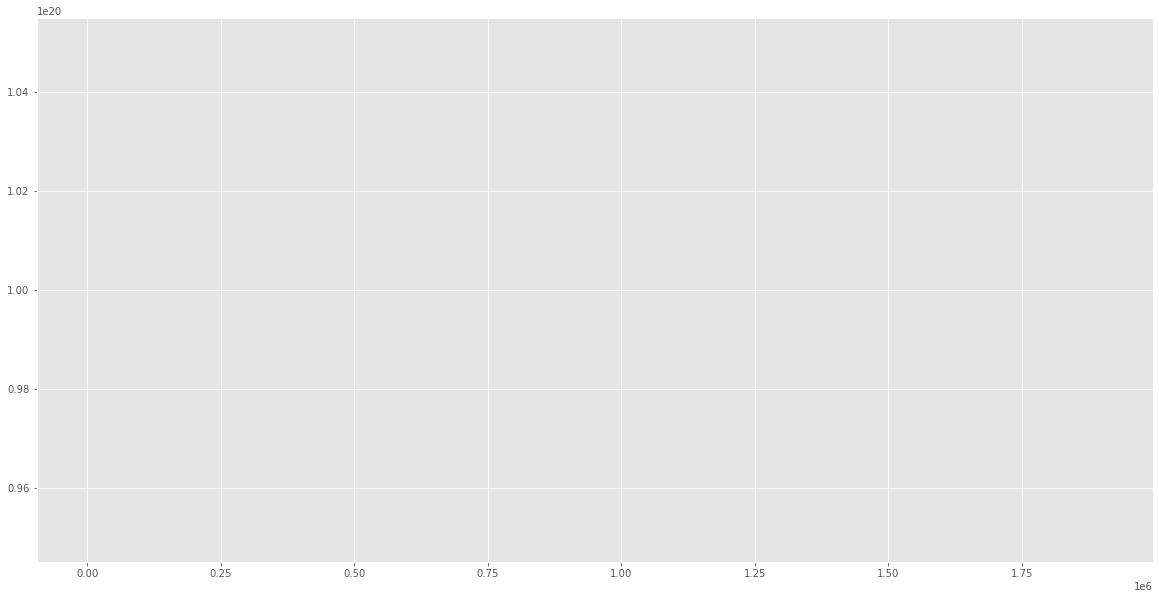

In [111]:
import matplotlib

matplotlib.style.use('ggplot')

# scatter plot of x = project vlue, y = number of vanues
plt.figure(figsize=(20,10))
plt.scatter(df['projectvalue'], df['NumofVenues'])
plt.show()

From the scatterplot, it doesn't look like there is a correlation between project value and the number of surrounding venues.

In [112]:
# pearson correlation
df['projectvalue'].corr(df['NumofVenues'])

nan

#### Consistent with the our impression with the graph, there is no correlation between project value and the number of surrounding venues.

## Results <a name="Results"></a>

#### There is no correlation between project value and the number of surrounding venues.